Installation


# RecSys - Matrix Factorization

The steps in the model are as follows:

+ Map user ID to a "user vector" via an embedding matrix
+ Map movie ID to a "movie vector" via an embedding matrix
+ Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
+ Train the embeddings via gradient descent using all known user-movie pairs.

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

!mkdir model

## Load Data and apply preprocessing

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")


def load_movies(movielens_dir):
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME)
    df.columns= ['movieId','title','movie_genre']
    return df


def load_ratings(movielens_dir):
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    df.columns=['userId','movieId','rating','timestamp']
    return df

df = load_ratings(movielens_dir)

5931008/5917549 [==============================] - 1s 0us/step
Extracting all the files now...
Done!


First, need to perform some preprocessing to encode users and movies as integer indices.


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 6040, Number of Movies: 3706, Min rating: 1.0, Max rating: 5.0


In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1193,5.0,978300760,0,0
1,1,661,3.0,978302109,0,1
2,1,914,3.0,978301968,0,2
3,1,3408,4.0,978300275,0,3
4,1,2355,5.0,978824291,0,4
...,...,...,...,...,...,...
1000204,6040,1091,1.0,956716541,6039,772
1000205,6040,1094,5.0,956704887,6039,1106
1000206,6040,562,5.0,956704746,6039,365
1000207,6040,1096,4.0,956715648,6039,152


### Prepare training and validation data

In [ ]:
df = df.sample(frac=1, random_state=42)


In [ ]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.floor(df.index.size * 0.1)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

df['for_testing'] = False
grouped = df.groupby('movie', group_keys=False).apply(assign_to_set)
df_train = df[grouped.for_testing == False]
df_val = df[grouped.for_testing == True]
print(df_train.shape)
print(df_val.shape)
print(df_train.index & df_val.index)

print("Training data_set has "+ str(df_train.shape[0]) +" ratings")
print("Test data set has "+ str(df_val.shape[0]) +" ratings")


x_train = df_train[["user", "movie"]].values
y_train = df_train["rating"].values

x_val = df_val[["user", "movie"]].values
y_val = df_val["rating"].values

(901777, 7)
(98432, 7)
Int64Index([], dtype='int64')
Training data_set has 901777 ratings
Test data set has 98432 ratings


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  


## Evaluation function

We make a function in order to plot the metrics/losses graphics once the model has been trained.

In [ ]:
def plot_train_val_losses(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.axis([0,len(history.history["loss"]),np.min(history.history["loss"]),np.max(history.history["val_loss"])])
    plt.show()

## Create MF model

We embed both users and movies in to 10-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.

In [ ]:
EMBEDDING_SIZE = 10

class RecommenderNetV(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNetV, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_movie_embedding = layers.Embedding(
            num_users+num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_movie_embedding(inputs[:, 0])
        movie_vector = self.user_movie_embedding(inputs[:, 1]+num_users)
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        return x


mf_model = RecommenderNetV(num_users, num_movies, EMBEDDING_SIZE)
mf_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.0005)
)

In [ ]:
tf.tensordot(mf_model.user_movie_embedding(np.array([1,2])) ,mf_model.user_movie_embedding(np.array([1,2])) ,2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.003113562>

## Train and evaluate MF model


In [ ]:
mf_history = mf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
7046/7046 [==============================] - 37s 5ms/step - loss: 2.4622 - val_loss: 0.9961
Epoch 2/5
7046/7046 [==============================] - 36s 5ms/step - loss: 0.9333 - val_loss: 0.8991
Epoch 3/5
7046/7046 [==============================] - 35s 5ms/step - loss: 0.8753 - val_loss: 0.8723
Epoch 4/5
7046/7046 [==============================] - 35s 5ms/step - loss: 0.8565 - val_loss: 0.8592
Epoch 5/5
7046/7046 [==============================] - 36s 5ms/step - loss: 0.8461 - val_loss: 0.8579


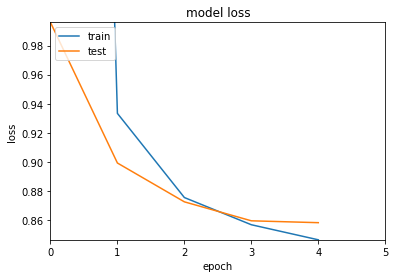

In [ ]:
plot_train_val_losses(mf_history)

# RecSys - DEEP Factorization Machines


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pathlib import Path
from zipfile import ZipFile
!mkdir models

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")


def load_ratings(movielens_dir):
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding="ISO-8859-1")
    return df

def load_movies(movielens_dir):
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding="ISO-8859-1")
    return df

def load_users(movielens_dir):
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv(movielens_dir / 'users.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding="ISO-8859-1")
    return df

def text2seq(text, n_genre):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq

n_genre = 15


ratings = load_ratings(movielens_dir)
movies = load_movies(movielens_dir)
users = load_users(movielens_dir)


print("====== rating.dat ======")
print(ratings.head())
print("===== movies.dat ======")
print(movies.head())
print("====== users.dat ======")
print(users.head())

movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()

ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
ratings = ratings.join(users.set_index('uid'), on = 'uid', how = 'left')
print("====== preprocessed data =======")
(ratings.head())

====== rating.dat ======
   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291
===== movies.dat ======
   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy
====== users.dat ======
   uid user_fea1  user_fea2  user_fea3 user_fea4
0    1         F          1         10     48067
1    2         M         56         16     70072
2    3         M         25         15     55117
3    4         M         45          7     02460
4    5         M         25         20     55455
===

,uid,mid,rating,timestamp,movie_name,movie_genre,user_fea1,user_fea2,user_fea3,user_fea4
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),"[13, 5, 0]",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067


In [ ]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.floor(df.index.size * 0.1)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

ratings['for_testing'] = False
grouped = ratings.groupby('mid', group_keys=False).apply(assign_to_set)

df_train = ratings[grouped.for_testing == False]
df_val = ratings[grouped.for_testing == True]
print(df_train.shape)
print(df_val.shape)
print(df_train.index & df_val.index)
print("Training data_set has "+ str(df_train.shape[0]) +" ratings")
print("Test data set has "+ str(df_val.shape[0]) +" ratings")
df_train.head()

(901777, 11)
(98432, 11)
Int64Index([], dtype='int64')
Training data_set has 901777 ratings
Test data set has 98432 ratings


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  from ipykernel import kernelapp as app


,uid,mid,rating,timestamp,movie_name,movie_genre,user_fea1,user_fea2,user_fea3,user_fea4,for_testing
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067,False
1,1,661,3,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067,False
2,1,914,3,978301968,My Fair Lady (1964),"[13, 5, 0]",F,1,10,48067,False
3,1,3408,4,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067,False
4,1,2355,5,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067,False


## Define input layers
The dataset contains a **numeric** and **categerical** features, they need to be treated differently.

* **numeric features** can be concatenated to inputs, with shape (None, num_of_numeric)
* **categorical features** can be encoded individually to inputs, with shape (None, 1) each.

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    # numerical features
    fea3_input = Input((1,), name = 'input_fea3')
    num_inputs = [fea3_input]
    # single level categorical features
    uid_input = Input((1,), name = 'input_uid') #user_id
    mid_input = Input((1,), name= 'input_mid')  #movie_id
    cat_sl_inputs = [uid_input, mid_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name = 'input_genre')
    cat_ml_inputs = [genre_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

inputs = define_input_layers()

## 1st order factorization machines
1st order will require features to map to a scalar. so for:

* numeric feature: a dense layer will convert tensor to shape (None,1)
* categorical feature: a embedding layer will convert tensor to shape (None,1,1) and then reshape layer to reshape to (None,1)

In [ ]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_mid, n_genre):
    
    # user feat3 + user embedding + movie embedding + genre embedding
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_fea4')(fea3_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input),
                        Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

y_1d = fm_1d(inputs, 10, 10, 10)

## 2nd order factorization machines
In 2nd order FM, each feature is map to shape (None, 1, k) and then stack to concat_embed_2d layer with shape (None, p, k).
k - matrix factorization latent dimension, p is feature dimension.

the calculation of interaction terms can be simplified, using
\begin{equation*} \sum{x_ix_j} = \frac{1}{2} \left((\sum{x})^2 - \sum({x}^2)\right) \end{equation*}

Hence, the sum of 2nd order interactions = square of sum of concat_embed_2d - sum of squared concat_embed_2d in p dimension, the resulting tensor will have a shape (None, k)



In [ ]:
def fm_2d(inputs, n_uid, n_mid, n_genre, k):
    
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_fea3')(fea3_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input), 
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = (0.5*[(sum of  xi)^2 - sum of (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

y_fm2_d, embed_2d = fm_2d(inputs, 10, 10, 10, 5)

## deep part
this part is simply a DNN framework with input as concat_embed_2d layer

In [ ]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = deep_part(embed_2d, [16, 16], 0.5)

## Put together

In [ ]:
def deep_fm_model(n_uid, n_mid, n_genre, k, dnn_dim, dnn_dr):
    
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_uid, n_mid, n_genre)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_mid, n_genre, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [ ]:
params = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_genre': 14,
    'k':20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}

fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [ ]:
params

{'dnn_dim': [64, 64],
 'dnn_dr': 0.5,
 'k': 20,
 'n_genre': 14,
 'n_mid': 3952,
 'n_uid': 6040}

## Prepare Data

### Split Data

In [ ]:
df_train.shape,df_val.shape

((901777, 11), (98432, 11))

In [ ]:
def df2xy(ratings):
    x = [ratings.user_fea3.values, 
         ratings.uid.values, 
         ratings.mid.values, 
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    y = ratings.rating.values
    return x,y

train_x, train_y = df2xy(df_train)
valid_x, valid_y = df2xy(df_val)

## Train Model

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
# train  model
deep_fm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='./models/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = deep_fm_model.fit(train_x, train_y, 
                                  epochs=30, batch_size=2048, 
                                  validation_data=(valid_x, valid_y),
                                  callbacks = callbacks)

Epoch 1/30
441/441 [==============================] - 9s 15ms/step - loss: 8.4261 - val_loss: 10.5175
Epoch 2/30
441/441 [==============================] - 6s 14ms/step - loss: 1.8377 - val_loss: 2.3442
Epoch 3/30
441/441 [==============================] - 7s 15ms/step - loss: 1.0501 - val_loss: 1.2204
Epoch 4/30
441/441 [==============================] - 6s 14ms/step - loss: 0.9389 - val_loss: 1.0382
Epoch 5/30
441/441 [==============================] - 6s 14ms/step - loss: 0.9039 - val_loss: 0.9345
Epoch 6/30
441/441 [==============================] - 6s 14ms/step - loss: 0.8824 - val_loss: 0.8986
Epoch 7/30
441/441 [==============================] - 6s 14ms/step - loss: 0.8674 - val_loss: 0.8795
Epoch 8/30
441/441 [==============================] - 6s 14ms/step - loss: 0.8575 - val_loss: 0.8622
Epoch 9/30
441/441 [==============================] - 6s 14ms/step - loss: 0.8509 - val_loss: 0.8567
Epoch 10/30
441/441 [==============================] - 7s 15ms/step - loss: 0.8449 - val_l

### Exercice

Modify the previous model to use Graph Embeddings